<a href="https://colab.research.google.com/github/oscarsiamo/Proyecto-DAC/blob/master/Dinamic_spectrum_Colombia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%pylab
%matplotlib inline
import healpy as hp
import time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation, Angle
from astropy.time import Time
from astropy.coordinates import AltAz
from astropy.time import TimeDelta
from astropy.coordinates import get_sun

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [16]:
T_Hmap = hp.read_map("lambda_haslam408_dsds.fits")  # read_map loads the first column

Temperature spectral index      

$\alpha= -\frac{log(T_1/T_2)}{log(v_1/v_2)}$ 

In [19]:
def T_freq(alpha,freq1,freq2,T1):
    return T1*10**(alpha*log10(freq1/freq2))

Tiempo(s): 0.5619065761566162


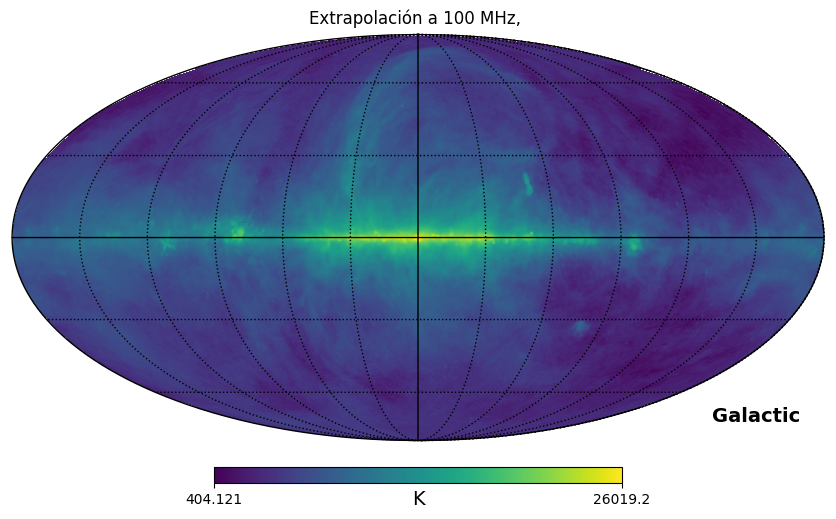

In [36]:
T_100=T_freq(2.54,408,100,T_Hmap)   #Scale (100 MHz)
start = time.time()
hp.mollview(T_100,
    coord=["G"],
    title="Extrapolación a 100 MHz, ",
    unit="K",
    norm="log")
hp.graticule() #adds meridians and parallels
end = time.time()
print('Tiempo(s):',end - start)

Tiempo(s): 0.6058444976806641


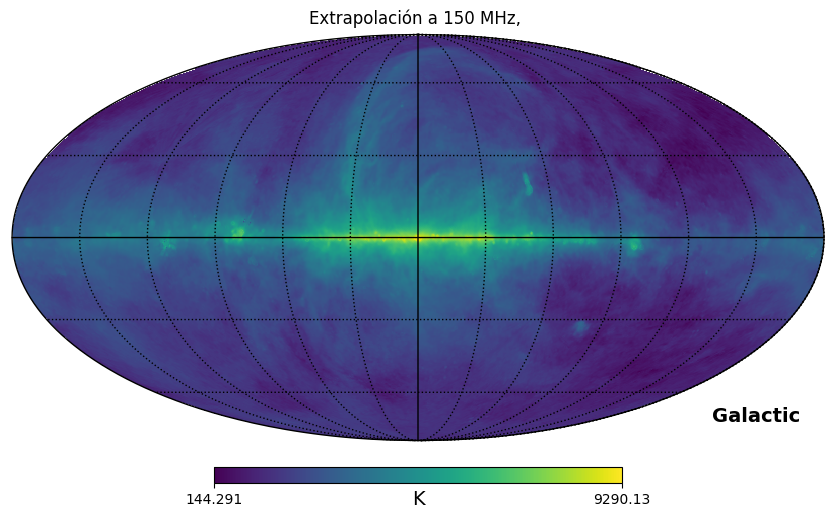

In [24]:
T_150=T_freq(2.54,408,150,T_Hmap)   #Extrapole (150 MHz)
start = time.time()
hp.mollview(T_150,
    coord=["G"],
    title="Extrapolación a 150 MHz, ",
    unit="K",
    norm="log")
hp.graticule() #adds meridians and parallels
end = time.time()
print('Tiempo(s):',end - start)

Tiempo(s): 0.9394845962524414


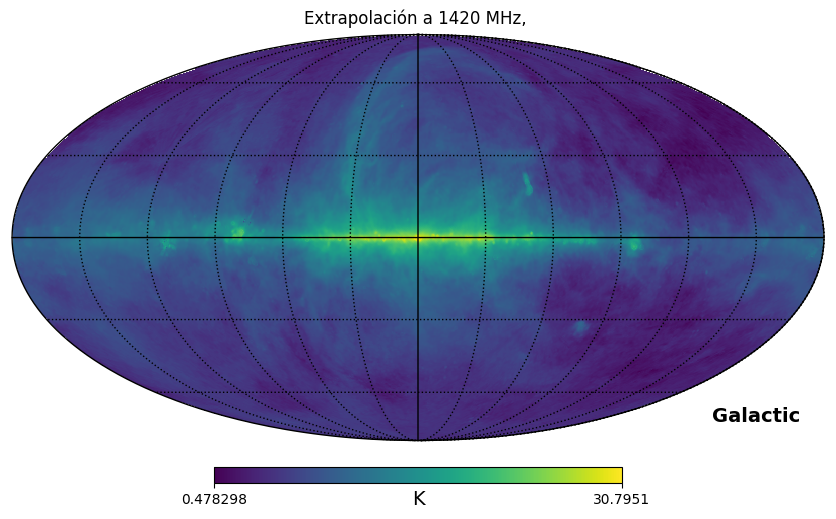

In [37]:
T_1420=T_freq(2.54,408,1420,T_Hmap)   #Extrapole (150 MHz)
start = time.time()
hp.mollview(T_1420,
    coord=["G"],
    title="Extrapolación a 1420 MHz, ",
    unit="K",
    norm="log")
hp.graticule() #adds meridians and parallels
end = time.time()
print('Tiempo(s):',end - start)

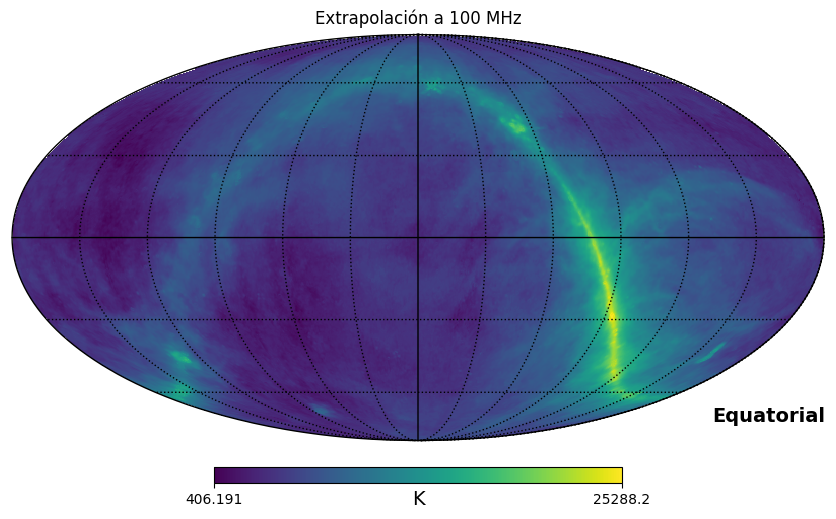

In [38]:
hp.mollview(T_100,
    coord=["G",'Equatorial'],
    title="Extrapolación a 100 MHz",
    unit="K",
    norm="log")
hp.graticule() #adds meridians and parallels

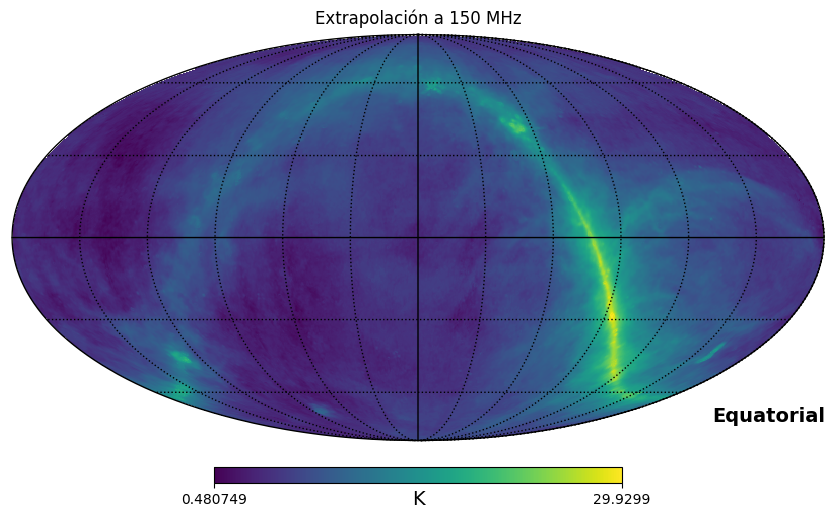

In [40]:
hp.mollview(T_150,
    coord=["G",'Equatorial'],
    title="Extrapolación a 150 MHz",
    unit="K",
    norm="log")
hp.graticule() #adds meridians and parallels

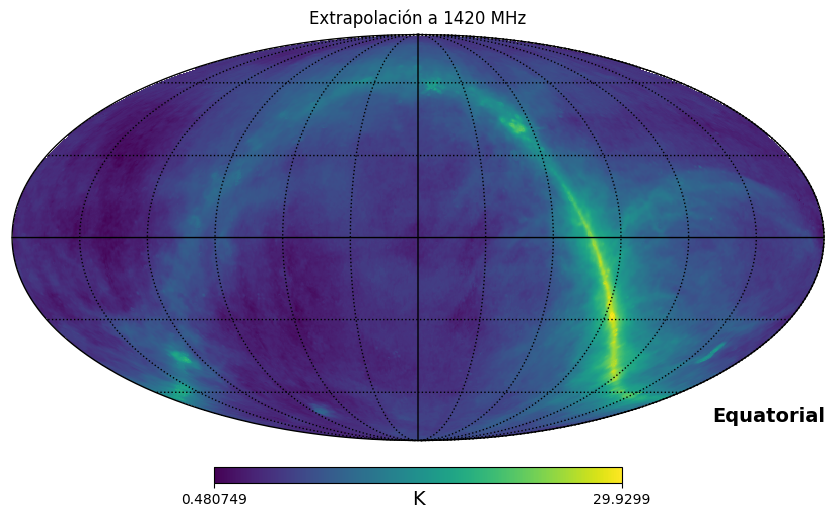

In [41]:
hp.mollview(T_1420,
    coord=["G",'Equatorial'],
    title="Extrapolación a 1420 MHz",
    unit="K",
    norm="log")
hp.graticule() #adds meridians and parallels

In [42]:
nside = hp.get_nside(T_Hmap)  #nside
npix = hp.nside2npix(nside)   #number of pixels

l, b = hp.pix2ang(nside, arange(npix), lonlat=True)   #(l, b) coordinates for each pixel
g_coord=SkyCoord(l*u.deg, b*u.deg, frame='galactic')  

nside, npix, l, b

(512,
 3145728,
 array([ 45., 135., 225., ..., 135., 225., 315.]),
 array([ 89.90862927,  89.90862927,  89.90862927, ..., -89.90862927,
        -89.90862927, -89.90862927]))

In [45]:
# The observatory location (Two methods)

#First method
ALMA_lat = Angle('-23d00m29s')
ALMA_lon = Angle('-67d45m12s')
obs_time = Time('2021-06-14 00:00:00')  # Observation date
ALMA_obs_loc = EarthLocation(lat=ALMA_lat.degree*u.deg, lon=ALMA_lon.degree*u.deg,
                                   height=5000*u.m)  # Lugar de observacion en Tierra (Ground Observation Site)

#Second method
Alma_loc=EarthLocation.of_site('ALMA') #Return an object of this class for a known observatory/site by name.

print(ALMA_obs_loc,Alma_loc)

(2225517.20089533, -5440791.8229643, -2479494.79525963) m (2225015.30883296, -5440016.41799762, -2481631.27428014) m


In [46]:
Alma_loc = EarthLocation.of_site('ALMA')
start_t=Time('2021-06-14T00:00:00',format='isot')

times1=start_t + TimeDelta(60*60, format='sec')*linspace(0,24,24)  #dt=1 hr
times30=start_t + TimeDelta(30*60, format='sec')*linspace(0,48,48) #dt=30 min

altaz1 = AltAz(location=Alma_loc, obstime=times1)
altaz30 = AltAz(location=Alma_loc, obstime=times30)

In [47]:
freqs10=arange(50,160,10) #MHz
freqs5=arange(50,155,5)
freqs1=arange(50,151,1)
freqs_ven=arange(40,85,1)

In [48]:
def Temps(fs,ts):  
    '''Takes frequencies (fs) and times (ts) and returns the Temperature matrix'''
    
    start = time.time()
    Temps=zeros((ts.obstime.size,len(fs)))
    for i in range (ts.obstime.size):
        aa_coord=g_coord.transform_to(ts[i])      #Galactic to Altaz
        mask=argwhere(aa_coord.alt>0)             #Only coordinates above the horizon
        T_sky=T_Hmap[mask]                        #Only those temperatures
        
        for j in range (len(fs)):
            T_f=T_freq(2.54,408,fs[j],T_sky)      #Extrapolation
            Temps[-i,j]=mean(T_f)                 #Mean temperature (bottom to top)
    end = time.time()
    print('Tiempo recorrido(s):',end - start)  
    return Temps

In [49]:
Temps1=Temps(freqs10,altaz1)  #dfreq=10MHz, dt=1hr

Tiempo recorrido(s): 91.45311307907104


In [50]:
Temps2=Temps(freqs5,altaz1)  #dfreq=5MHz, dt=1hr

Tiempo recorrido(s): 86.98269510269165


In [51]:
Temps3=Temps(freqs1,altaz1)  #dfreq=1MHz, dt=1hr

Tiempo recorrido(s): 108.43398451805115


In [52]:
Temps4=Temps(freqs1,altaz30)  #dfreq=1MHz, dt=30min

Tiempo recorrido(s): 178.41757202148438


In [53]:
Temps5=Temps(freqs_ven,altaz30)  #dfreq=1MHz, dt=30min

Tiempo recorrido(s): 168.26403999328613


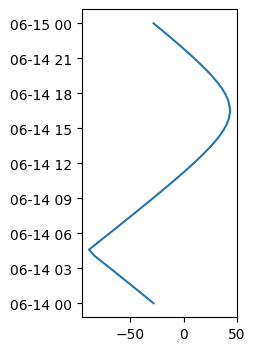

In [54]:
altaz_sun=get_sun(times30).transform_to(altaz30)    #LST
figure(figsize=(2,4))
plot(altaz_sun.alt,times30.to_datetime())

(Text(0.5, 1.0, 'dfreq=5 MHz, dt=1 hr'), Text(0.5, 0, 'freq (MHz)'))

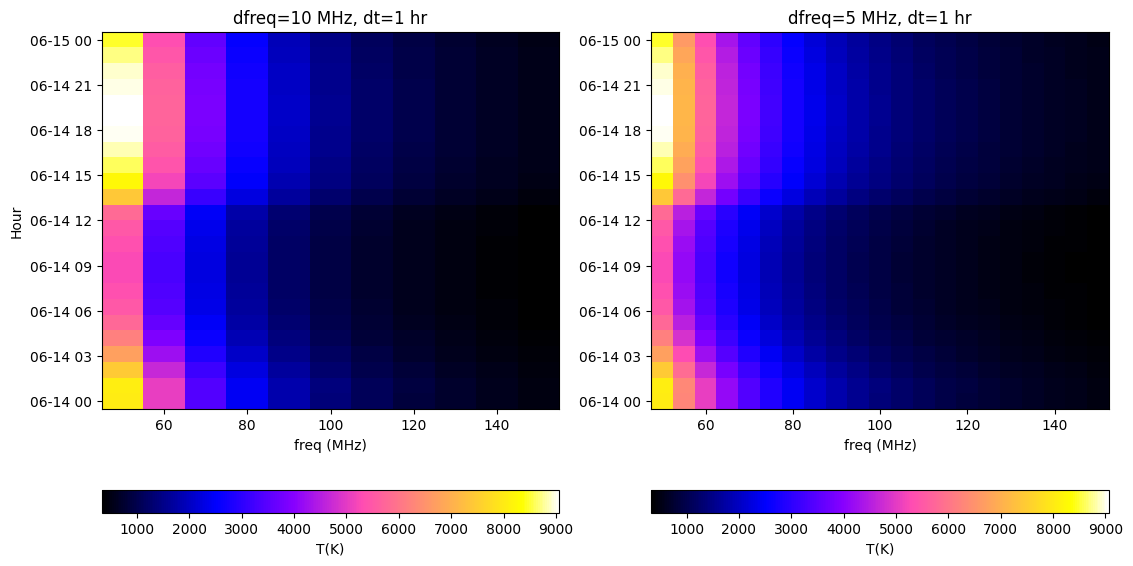

In [55]:
figure(figsize=(13,7))
subplot(1,2,1)
pcolormesh(freqs10,times1.to_datetime(), Temps1,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("dfreq=10 MHz, dt=1 hr"),xlabel('freq (MHz)'),ylabel('Hour')

subplot(1,2,2)
pcolormesh(freqs5,times1.to_datetime(), Temps2,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("dfreq=5 MHz, dt=1 hr"),xlabel('freq (MHz)')

(Text(0.5, 1.0, 'dfreq=1 MHz, dt=30 min'), Text(0.5, 0, 'freq (MHz)'))

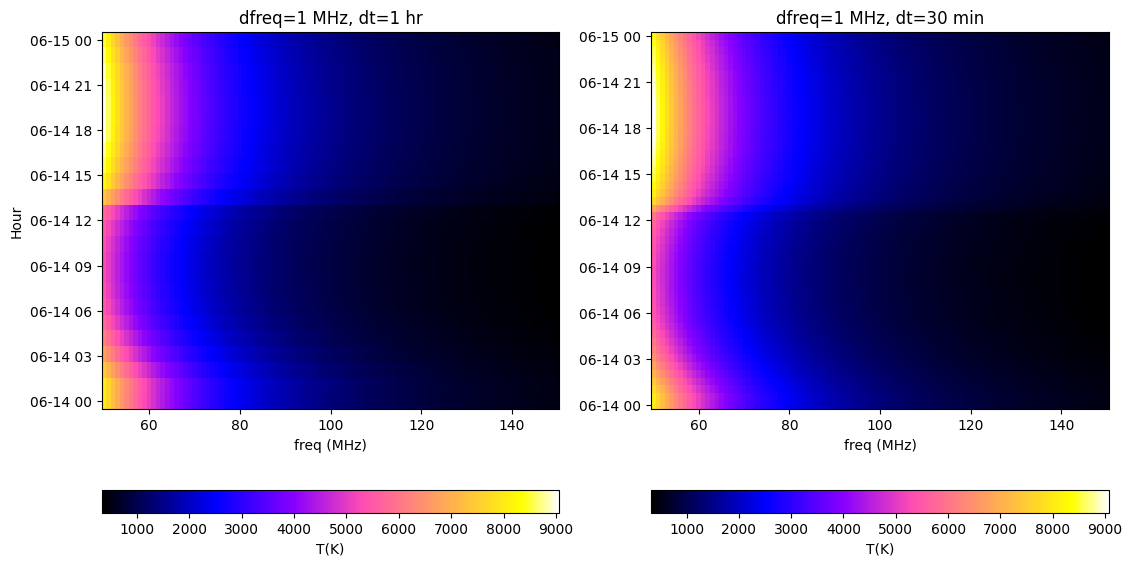

In [56]:
figure(figsize=(13,7))
subplot(1,2,1)
pcolormesh(freqs1,times1.to_datetime(), Temps3,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("dfreq=1 MHz, dt=1 hr"),xlabel('freq (MHz)'),ylabel('Hour')
subplot(1,2,2)
pcolormesh(freqs1,times30.to_datetime(), Temps4,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("dfreq=1 MHz, dt=30 min"),xlabel('freq (MHz)')

(Text(0.5, 1.0, 'dfreq=1 MHz, dt=30 min'), Text(0.5, 0, 'freq (MHz)'))

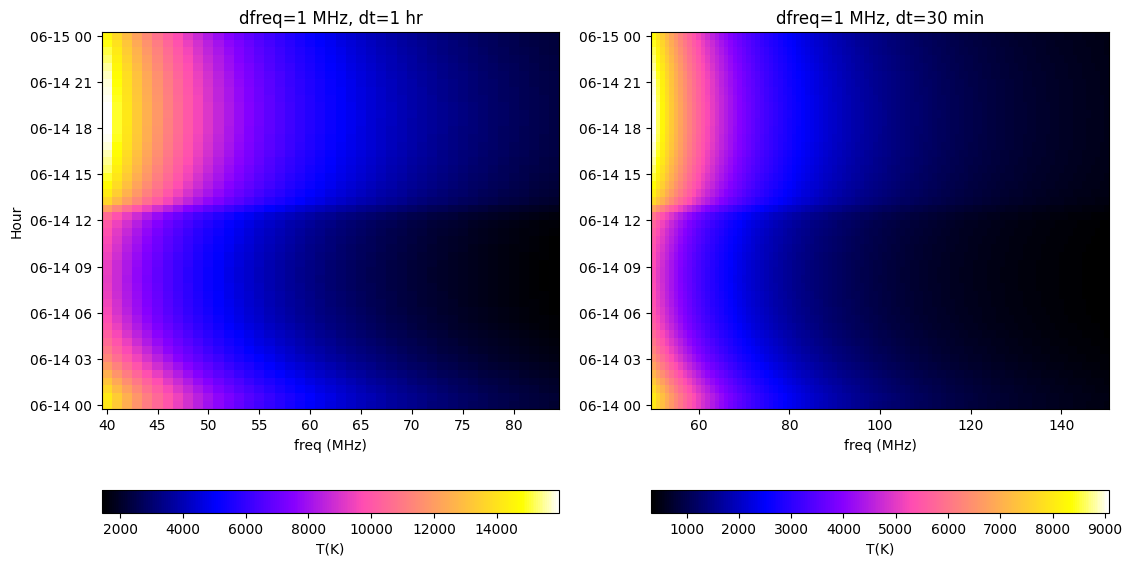

In [57]:
figure(figsize=(13,7))
subplot(1,2,1)
pcolormesh(freqs_ven,times30.to_datetime(), Temps5,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("dfreq=1 MHz, dt=1 hr"),xlabel('freq (MHz)'),ylabel('Hour')
subplot(1,2,2)
pcolormesh(freqs1,times30.to_datetime(), Temps4,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("dfreq=1 MHz, dt=30 min"),xlabel('freq (MHz)')